# 1.0 Overview
I used PyCaret - an open source, low-code machine learning library in Python that automates machine learning workflow. It is an end-to-end machine learning and model management tool that speeds up machine learning experiment cycle and makes you more productive.


### 1.1 Summary of workflow
1. I kept 5% of the data unseen to the model
2. Split the remaining 95% data into training and test set on the ratio 70:30
3. I trained on 5 folds CV
4. I used **Recall** as the metric to evaluate models and randome forest was the best model.
5. I tested and tuned the selected model on the 30% test data
6. I merged the training and test set in step 2 above to create a final random forest model.
7. I tested the final model on the unseen data in step 1 above to determine its performance.

### 1.2 Hypothesis:
One of the hypotheses under consideration is that **churn is driven by the customers’ price sensitivities** and that it is possible to predict customers likely to churn using a predictive model. The client also wants to try a discounting strategy, with the head of the SME division suggesting that offering customers at high propensity to churn a 20% discount might be effective.

### 1.3 My Conclusion
From the random forest model, i discovered churn is not due to price sensitivity alone. In fact, price does not work alone, it is affected by another variable which causes customers to churn. Similar to other variables that influences churn, they don't work alone, they are influenced by other variables.

**The most important variables in predicting customer churn are (in hierarchical order):**

1. Electricity consumption of the past 12 months
2. Interaction of forecasted power price for 1st period and electricity consumption of the past 12 months
3. Interaction of price of energy for the 2nd period and electricity consumption of the past 12 months
4. Subscribed power
5. Interaction of electricity consumption of the past 12 months and subscribed power
6. Interaction of electricity campaign the customer first subscribed to and electricity consumption of the past 12 months.
7. forecasted bill of meter rental for the next 12 months.


From the above, introducing a 20% discount strategy for customers with high propensity to churn will not dramatically lower churn rate. However, we can recommend tactics to reduce customer churn as applying different churn strategy across various user segments which will enable the client focus attention on its best customers and allocate more resources to retaining them.

## 2.0 Feature Engineering Methods Applied

1. **Normalization:** Normalization / Scaling (often used interchangeably with standardization) is used to transform the actual values of numeric variables in a way that provides helpful properties for machine learning. Many algorithms such as Logistic Regression, Support Vector Machine, K Nearest Neighbors and Naive Bayes assume that all features are centered around zero and have variances that are at at the same level of order. If a particular feature in a dataset has a variance that is larger in order of magnitude than other features, the model may not understand all features correctly and could perform poorly.

2. **Transformation:** While normalization transforms the range of data to remove the impact of magnitude in variance, transformation is a more radical technique as it changes the shape of the distribution so that transformed data can be represented by a normal or approximate normal distirbution. In general, you should transform the data if using algorithms that assume normality or a gaussian distribution. Examples of such models are Logistic Regression, Linear Discriminant Analysis (LDA) and Gaussian Naive Bayes.

3. **Ignore Low Variance:** Datasets can sometimes contain categorical features that have a single unique or small number of values across samples. This kind of features are not only non-informative and add no value but are also sometimes harmful for few algorithms.

4. **Multi-collinearity:** Multi-collinearity is a state of very high intercorrelations or inter-associations among the independent features in the dataset. It is a type of disturbance in the data that is not handled well by machine learning models (mostly linear algorithms). Multi-collinearity may reduce overall coefficient of the model and cause unpredictable variance. This will lead to overfitting where the model may do great on a known training set but will fail with an unknown testing set.

5. **Fix Imbalance:** From our data, only 10% of the clients churned hence we have a highly imbalanced data and we fix this using SMOTE technique.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *

In [2]:
%matplotlib inline 
sns.set(color_codes=True)
pd.set_option('display.max_columns', 100)

In [3]:
dataset = pd.read_csv('processed_data.csv')

data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

dates = ['id','date_activ', 'date_end','date_modif_prod','date_renewal','price_date']
data = data.drop(dates, axis = 1)
data_unseen = data_unseen.drop(dates, axis=1)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (165017, 27)
Unseen Data For Predictions: (8685, 27)


In [4]:
exp = pycaret.classification.setup(data, target = "churn", session_id=123,
                                  normalize = True, 
                                  transformation = True, 
                                  ignore_low_variance = True,
                                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                                   feature_interaction = True,
                                   feature_selection = True,
                                   fix_imbalance = True)

,Description,Value
0,session_id,123
1,Target,churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(165017, 27)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


## 3.0 Comparing Models

#### 3.1 Select the best model that performs best on the training data based on its sensitivity or recall performance

In [5]:
select_model = compare_models(exclude = ['knn', 'gbc', 'xgboost'], sort = 'Recall', fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9975,1.0000,1.0000,0.9780,0.9889,0.9875,0.9875,4.5440
svm,SVM - Linear Kernel,0.9981,0.0000,1.0000,0.9828,0.9913,0.9902,0.9903,1.1040
ridge,Ridge Classifier,0.9859,0.0000,1.0000,0.8883,0.9404,0.9325,0.9349,0.6820
rf,Random Forest Classifier,0.9999,1.0000,1.0000,0.9991,0.9996,0.9995,0.9995,4.0380
lda,Linear Discriminant Analysis,0.9877,0.9978,1.0000,0.8992,0.9469,0.9400,0.9417,2.2160
catboost,CatBoost Classifier,0.9999,1.0000,1.0000,0.9991,0.9996,0.9995,0.9995,40.1860
lightgbm,Light Gradient Boosting Machine,0.9998,1.0000,0.9999,0.9984,0.9992,0.9991,0.9991,3.4740
dt,Decision Tree Classifier,0.9999,1.0000,0.9998,0.9994,0.9996,0.9996,0.9996,1.1140
ada,Ada Boost Classifier,0.9999,1.0000,0.9998,0.9994,0.9996,0.9996,0.9996,11.4660
et,Extra Trees Classifier,0.9999,1.0000,0.9998,0.9994,0.9996,0.9996,0.9996,3.5440


Almost all the models perform very well on average over 5 folds. However these performances are on the training data and it needs to be evaluated on the test data. 
I will use random forest model.

In [6]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9999,1.0000,0.9992,1.0000,0.9996,0.9996,0.9996
1,0.9999,1.0000,1.0000,0.9992,0.9996,0.9996,0.9996
2,0.9998,1.0000,1.0000,0.9984,0.9992,0.9991,0.9991
3,0.9998,1.0000,1.0000,0.9984,0.9992,0.9991,0.9991
4,0.9999,1.0000,1.0000,0.9992,0.9996,0.9996,0.9996
5,0.9998,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9999,1.0000,1.0000,0.9992,0.9996,0.9996,0.9996
9,0.9998,1.0000,1.0000,0.9984,0.9992,0.9991,0.9991


#### 3.2 Tuning the random forest model

In [7]:
tuned_rf = tune_model(rf, fold = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9999,1.0000,1.0000,0.9991,0.9995,0.9995,0.9995
1,0.9999,1.0000,0.9995,1.0000,0.9998,0.9997,0.9997
Mean,0.9999,1.0000,0.9998,0.9995,0.9996,0.9996,0.9996
SD,0.0000,0.0000,0.0002,0.0005,0.0001,0.0001,0.0001


#### 3.3 Evaluating the parameters of the model

In [15]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**AUC Plot**

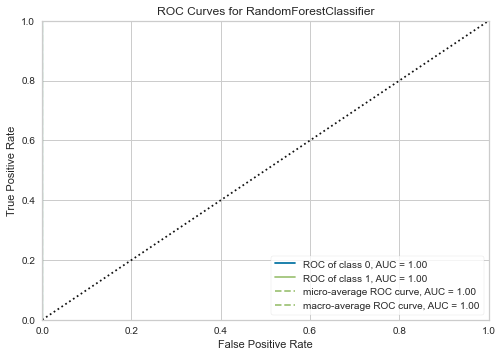

In [9]:
plot_model(tuned_rf, plot = 'auc')

**Precision/Recall Curve**

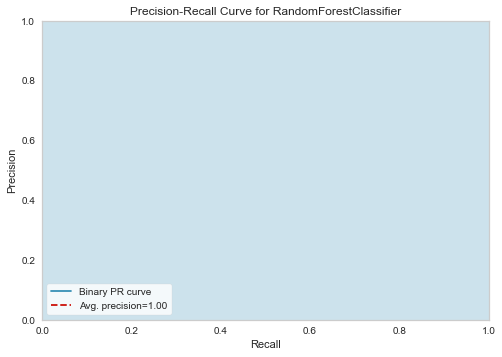

In [10]:
plot_model(tuned_rf, plot = 'pr')

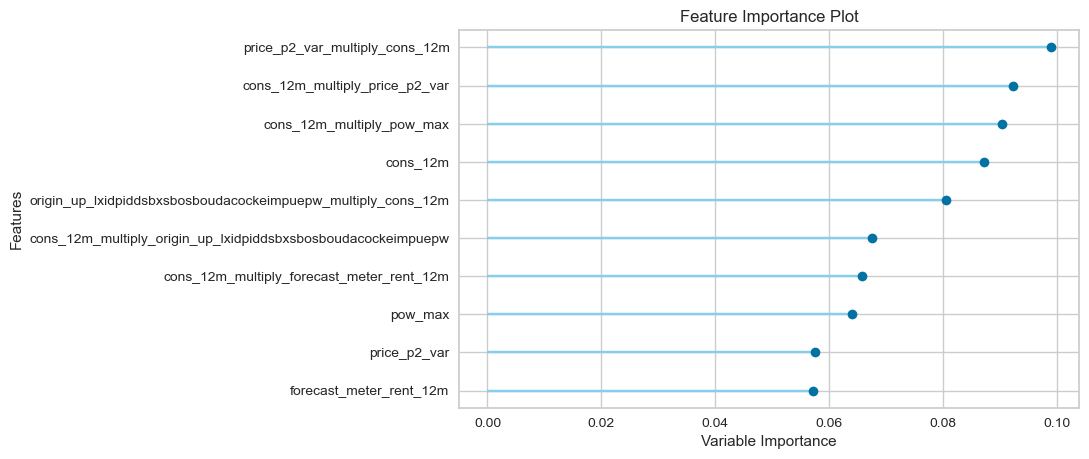

In [16]:
plot_model(tuned_rf, plot='feature')

#### 3.5 Predict on test / hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. As stated earlier, 30% of the data has been separated out as test/hold-out sample. All of the evaluation metrics we have seen above are cross validated results based on the training set (70%) only. Now, using our final trained model stored in the tuned_rf variable we will predict against the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [11]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9999,1.0000,1.0000,0.9991,0.9995,0.9995,0.9995


,num_years_antig_13,nb_prod_act_4,nb_prod_act_5,num_years_antig_10,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,origin_up_lxidpiddsbxsbosboudacockeimpuepw,pow_max,nb_prod_act_32,nb_prod_act_1,channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds,...,nb_prod_act_32_multiply_pow_max,origin_up_lxidpiddsbxsbosboudacockeimpuepw_multiply_cons_12m,channel_sales_usilxuppasemubllopkaafesmlibmsdf_multiply_origin_up_lxidpiddsbxsbosboudacockeimpuepw,cons_12m_multiply_channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf_multiply_pow_max,pow_max_multiply_num_years_antig_13,cons_12m_multiply_forecast_meter_rent_12m,churn,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,-1.444894,0.0,1.0,0.0,...,-0.0,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.784808,0,0,0.9999
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.475917,0.0,1.0,0.0,...,-0.0,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.505401,0,0,0.9999
2,0.0,0.0,0.0,0.0,1.0,1.0,1.450107,0.0,0.0,0.0,...,0.0,1.639140,0.0,1.639140,0.000000,0.0,1.771065,0,0,0.9998
3,0.0,0.0,0.0,0.0,0.0,1.0,1.754063,0.0,0.0,0.0,...,0.0,2.350689,1.0,0.000000,1.754063,0.0,2.590913,1,1,0.9998
4,0.0,0.0,0.0,0.0,0.0,1.0,-0.216351,0.0,1.0,0.0,...,-0.0,-0.422132,0.0,-0.000000,-0.000000,-0.0,0.057236,0,0,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49501,0.0,0.0,0.0,0.0,0.0,0.0,-0.646719,0.0,1.0,0.0,...,-0.0,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.660243,0,0,0.9999
49502,0.0,0.0,0.0,0.0,0.0,0.0,-1.253358,0.0,1.0,0.0,...,-0.0,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.702235,0,0,0.9999
49503,0.0,0.0,0.0,0.0,0.0,1.0,0.617591,0.0,1.0,0.0,...,0.0,0.072809,0.0,0.000000,0.000000,0.0,0.071430,0,0,0.9999
49504,0.0,0.0,0.0,0.0,0.0,0.0,-1.444894,0.0,1.0,0.0,...,-0.0,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.767133,0,0,0.9999


The accuracy on test/hold-out set is. 0.99. This is not a significant difference. If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting but could also be due to several other factors and would require further investigation. In this case, we will move forward with finalizing the model and predicting on unseen data (the 5% that we had separated in the beginning and never exposed to training).

## 4.0 Finalize Model for Deployment

Model finalization is the last step in the experiment.
I started the machine learning workflow in with setup(), followed by comparing all models and shortlisting a few candidate models (based on **recall**).

This workflow will eventually lead to selecting **random forest** as the best model for use in making predictions on new and unseen data.

The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [12]:
final_rf = finalize_model(tuned_rf)

## 5.0 Predict on unseen data

The predict_model() function is also used to predict on the unseen dataset. The only difference from the above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning and contains 5% of the original dataset which was never exposed to training.

In [13]:
unseen_predictions = predict_model(final_rf, data=data_unseen)
unseen_predictions.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,...,pow_max,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn,Label,Score
0,foosdfpfkusacimwkcsosbicdxkicaua,2608,0,0,235.90,0,0.0,11.25,0.112930,0.0,...,10.392,0.118175,0.0,0.0,40.565969,0.0,0.0,0,0,0.9999
1,foosdfpfkusacimwkcsosbicdxkicaua,2609,0,0,236.22,0,0.0,11.25,0.112930,0.0,...,10.392,0.118175,0.0,0.0,40.565969,0.0,0.0,0,0,0.9999
2,foosdfpfkusacimwkcsosbicdxkicaua,2613,0,0,236.44,0,0.0,11.28,0.112930,0.0,...,10.392,0.118175,0.0,0.0,40.565969,0.0,0.0,0,0,0.9999
3,foosdfpfkusacimwkcsosbicdxkicaua,2615,0,0,237.03,0,0.0,11.34,0.113206,0.0,...,10.392,0.118175,0.0,0.0,40.565969,0.0,0.0,0,0,0.9999
4,foosdfpfkusacimwkcsosbicdxkicaua,2616,0,0,237.09,0,0.0,11.34,0.113206,0.0,...,10.392,0.118175,0.0,0.0,40.565969,0.0,0.0,0,0,0.9999


### Saving the model

In [14]:
save_model(final_rf,'Final RF Model 25Dec2020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='churn',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight='balanced_subsample',
                                         criterion='gini', max_depth=6,
                                         max_features

In [17]:
final_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [19]:
data_predictions = predict_model(final_rf, data = data)
data_predictions.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,...,pow_max,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn,Label,Score
0,lmkebamcaaclubfxadlmueccxoimlema,287252,15063,25744,5212.75,4723,0.0,143.80,0.164057,0.100243,...,33.000,0.167699,0.105428,0.074570,44.444710,24.437330,16.291555,0,0,0.9813
1,foosdfpfkusacimwkcsosbicdxkicaua,8296,0,48,701.36,0,0.0,16.67,0.116900,0.000000,...,13.200,0.127710,0.000000,0.000000,40.728885,0.000000,0.000000,0,0,0.9999
2,foosdfpfkusacimwkcsosbicdxkicaua,37402,0,3026,2254.76,1508,0.0,130.35,0.145711,0.098142,...,17.321,0.150211,0.100505,0.071536,44.266931,24.339581,16.226389,0,0,0.9999
3,foosdfpfkusacimwkcsosbicdxkicaua,9183,0,201,766.01,0,0.0,16.98,0.116910,0.000000,...,13.200,0.129300,0.000000,0.000000,40.728885,0.000000,0.000000,0,0,0.9999
4,foosdfpfkusacimwkcsosbicdxkicaua,9551,0,258,793.55,0,0.0,17.21,0.116910,0.000000,...,13.200,0.129444,0.000000,0.000000,41.063970,0.000000,0.000000,0,0,0.9999


In [20]:
data_predictions.to_csv('data_predictions.csv', index = False)